In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Dacia.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_1310,Seri_Jogger,Seri_Lodgy,...,Model_1.6 MCV Black Line,Model_1.6 SCE Eco-G Ambiance,Model_1.6 Stepway,Model_L,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,565999,0.545455,-0.333333,-3.182692,-0.636704,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,285000,-0.181818,-0.888889,-0.475962,0.599251,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,435000,0.454545,-0.333333,-0.475962,-0.074906,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,645000,0.818182,0.222222,0.182692,-0.753184,0.0,1.0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
4,447000,0.272727,-0.333333,-0.475962,0.307116,2.0,1.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_3840\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,46407.024727,2.960256e+09,54408.237157,36655.451464


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:49:14,996] A new study created in memory with name: no-name-cb844290-8b41-4918-b2e3-a03c8ee8df82
[I 2023-05-23 20:49:15,118] Trial 2 finished with value: 363523.8196577616 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.021806173832048654, 'max_depth': 7, 'min_child_weight': 292}. Best is trial 2 with value: 363523.8196577616.
[I 2023-05-23 20:49:15,119] Trial 3 finished with value: 438307.6444771057 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.4076038470234053, 'max_depth': 6, 'min_child_weight': 282}. Best is trial 2 with value: 363523.8196577616.
[I 2023-05-23 20:49:15,120] Trial 0 finished with value: 349002.7983094646 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.02412970464237128, 'max_depth': 5, 'min_child_weight': 111}. Best is trial 0 with value: 349002.7983094646.
[I 2023-05-23 20:49:15,122] Trial 7 finished with value: 409214.52539910376 and parameters: {'colsam

[I 2023-05-23 20:49:16,080] Trial 29 finished with value: 59074.044605719835 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4109363763251682, 'max_depth': 11, 'min_child_weight': 137}. Best is trial 25 with value: 49427.890484802745.
[I 2023-05-23 20:49:16,145] Trial 31 finished with value: 51329.65207856688 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4570349182749971, 'max_depth': 10, 'min_child_weight': 2}. Best is trial 25 with value: 49427.890484802745.
[I 2023-05-23 20:49:16,196] Trial 32 finished with value: 51008.32513962444 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.48422363774192123, 'max_depth': 10, 'min_child_weight': 5}. Best is trial 25 with value: 49427.890484802745.
[I 2023-05-23 20:49:16,272] Trial 33 finished with value: 52641.43378557041 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.4690305928079696, 'max_depth': 10, 'min_child_weight

[I 2023-05-23 20:49:17,621] Trial 60 finished with value: 58050.121043220934 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4923547049525608, 'max_depth': 5, 'min_child_weight': 67}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:17,680] Trial 62 finished with value: 59678.25778867318 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.34666154607100264, 'max_depth': 5, 'min_child_weight': 68}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:17,688] Trial 61 finished with value: 62225.79758359391 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.33963160477133375, 'max_depth': 5, 'min_child_weight': 107}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:17,745] Trial 63 finished with value: 58660.20109412007 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3491956340655472, 'max_depth': 5, 'min_child_weight'

[I 2023-05-23 20:49:19,023] Trial 90 finished with value: 59424.07367802597 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.28280913359720955, 'max_depth': 11, 'min_child_weight': 57}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:19,026] Trial 91 finished with value: 147534.90753928412 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2958414431330271, 'max_depth': 11, 'min_child_weight': 207}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:19,174] Trial 92 finished with value: 59680.526244608605 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2810822835401489, 'max_depth': 11, 'min_child_weight': 54}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:19,233] Trial 93 finished with value: 69687.39070656702 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.27997712317076134, 'max_depth': 12, 'min_child_we

[I 2023-05-23 20:49:20,684] Trial 120 finished with value: 52450.34242661072 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3406759193458448, 'max_depth': 10, 'min_child_weight': 33}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:20,688] Trial 121 finished with value: 51186.17892670215 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3560855969133849, 'max_depth': 10, 'min_child_weight': 31}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:20,702] Trial 122 finished with value: 52634.448198317245 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3346669349527624, 'max_depth': 10, 'min_child_weight': 31}. Best is trial 56 with value: 49263.920647079605.
[I 2023-05-23 20:49:20,743] Trial 123 finished with value: 52420.32481944433 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3407862591714625, 'max_depth': 10, 'min_child_we

[I 2023-05-23 20:49:22,460] Trial 149 finished with value: 48898.804149747826 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.44261849106884965, 'max_depth': 15, 'min_child_weight': 5}. Best is trial 149 with value: 48898.804149747826.
[I 2023-05-23 20:49:22,572] Trial 151 finished with value: 50810.633241411044 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.47313878415456523, 'max_depth': 15, 'min_child_weight': 6}. Best is trial 149 with value: 48898.804149747826.
[I 2023-05-23 20:49:22,704] Trial 152 finished with value: 50546.988292305236 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.4994260035002164, 'max_depth': 14, 'min_child_weight': 7}. Best is trial 149 with value: 48898.804149747826.
[I 2023-05-23 20:49:22,757] Trial 154 finished with value: 267279.4709373174 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.05120865049259795, 'max_depth': 15, 'min_chi

[I 2023-05-23 20:49:24,313] Trial 179 finished with value: 53654.08165023254 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.4245430644292182, 'max_depth': 13, 'min_child_weight': 25}. Best is trial 166 with value: 48885.55823284756.
[I 2023-05-23 20:49:24,395] Trial 181 finished with value: 52424.685554258795 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.4130529436005466, 'max_depth': 13, 'min_child_weight': 23}. Best is trial 166 with value: 48885.55823284756.
[I 2023-05-23 20:49:24,396] Trial 182 finished with value: 51686.43159629256 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.41107156862872385, 'max_depth': 13, 'min_child_weight': 24}. Best is trial 166 with value: 48885.55823284756.
[I 2023-05-23 20:49:24,412] Trial 183 finished with value: 130282.81519794541 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.13517183174285835, 'max_depth': 13, 'min_child

[I 2023-05-23 20:49:26,279] Trial 209 finished with value: 48420.24681981812 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49720820036999946, 'max_depth': 15, 'min_child_weight': 14}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:26,390] Trial 211 finished with value: 48416.16861754853 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4967965248004067, 'max_depth': 15, 'min_child_weight': 14}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:26,426] Trial 212 finished with value: 49476.519834404426 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.48352931744607447, 'max_depth': 15, 'min_child_weight': 19}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:26,500] Trial 213 finished with value: 49330.77719272792 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4269712092126985, 'max_depth': 15, 'min_child_

[I 2023-05-23 20:49:28,273] Trial 240 finished with value: 135521.82512372747 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1202665623164269, 'max_depth': 15, 'min_child_weight': 22}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:28,386] Trial 241 finished with value: 49797.94951296212 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4478364624546344, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:28,387] Trial 242 finished with value: 51086.90313974415 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4872227206222011, 'max_depth': 15, 'min_child_weight': 36}. Best is trial 210 with value: 47913.35491162663.
[I 2023-05-23 20:49:28,588] Trial 244 finished with value: 48698.36745402032 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4985062069727516, 'max_depth': 15, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 47913.3549
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4974494609705633
	max_depth: 15
	min_child_weight: 13


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [8,15],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [1],
               'min_child_weight': [13]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 13, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 44087.942997621794, 'MSE': 2421098901.0431175, 'RMSE': 49204.663407477114, 'MAE': 35759.54263041339}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8875948389167126

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8748697263412462

In [17]:
marka_model = joblib.dump(grid_final_model, "Dacia.pkl")

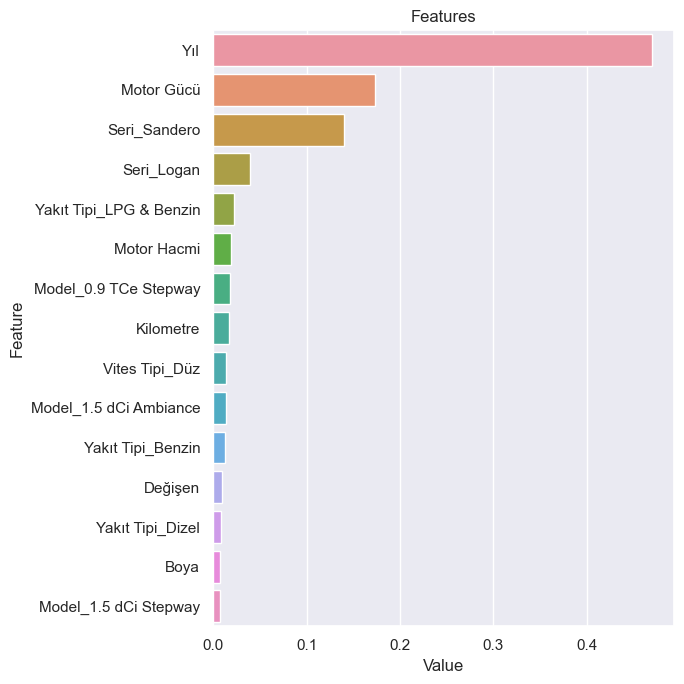

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)